### 원본 IMDB 텍스트 다운로드하기

먼저 http://mng.bz/0tIo 에서 IMDB 원본 데이터셋을 다운로드하고 압축을 해제합니다.

훈련용 리뷰 하나를 문자열 하나로 만들어 훈련 데이터를 문자열의 리스트로 구성해 보죠. 리뷰 레이블(긍정/부정)도 `labels` 리스트로 만들겠습니다:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 현재 작업 경로 확인
# 기본 설정은 root입니다.
%cd

https://rfriend.tistory.com/600


In [ ]:
# 드라이브에 aclImdb.zip 파일을 업로드 해놓습니다. (시간 많이 걸리지 않습니다.)
# 드라이브를 마운트 합니다.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 이제 zipfile 라이브러리를 사용하여 압축을 해제합니다.
# 이 작업은 작업경로(root)에서 진행됩니다.
import zipfile

zf = zipfile.ZipFile('drive/MyDrive/cakd5_colab/m9_딥러닝알고리즘구현/datasets/aclImdb.zip')
zf.extractall()
zf.close()

In [3]:
!pwd

/content


In [4]:
import os

# 현재 imdb 데이터가 있는 경로는 다음과 같습니다.
imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [5]:
texts[0]

'My husband is a huge Robin Williams fan. I like him too, but have generally found that he should "stick to what he does best" and focus on comedic roles. My thoughts were confirmed with this movie. I was completely bored throughout the entire film. The story was predictable. I realize it was inspired by a true story. But, my guess is that there could have been some suspense or intrigue even while maintaining truth in the story. None of the characters were well developed. There was a side story about the main character and his partner. This relationship could have been explored further. More important, though, would have been a deeper exploration of the mother of the "boy". Her psychological profile would have been interesting to delve into. She obviously has a long history that was not touched upon except in the most superficial way. If my husband wasn\'t such a huge Williams fan, we would have left 20 minutes into it. Too bad I can\'t get my $20 or 2 hours back.'

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # 100개 단어 이후는 버립니다
training_samples = 200  # 훈련 샘플은 200개입니다
validation_samples = 10000  # 검증 샘플은 10,000개입니다
max_words = 10000  # 데이터셋에서 가장 빈도 높은 10,000개의 단어만 사용합니다

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)

# 데이터를 훈련 세트와 검증 세트로 분할합니다.
# 샘플이 순서대로 있기 때문에 (부정 샘플이 모두 나온 후에 긍정 샘플이 옵니다) 
# 먼저 데이터를 섞습니다.
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 100)
레이블 텐서의 크기: (25000,)


In [7]:
word_index.items()

dict_items([('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('br', 7), ('in', 8), ('it', 9), ('i', 10), ('this', 11), ('that', 12), ('was', 13), ('as', 14), ('for', 15), ('with', 16), ('movie', 17), ('but', 18), ('film', 19), ('on', 20), ('not', 21), ('you', 22), ('are', 23), ('his', 24), ('have', 25), ('he', 26), ('be', 27), ('one', 28), ('all', 29), ('at', 30), ('by', 31), ('an', 32), ('they', 33), ('who', 34), ('so', 35), ('from', 36), ('like', 37), ('her', 38), ('or', 39), ('just', 40), ('about', 41), ("it's", 42), ('out', 43), ('has', 44), ('if', 45), ('some', 46), ('there', 47), ('what', 48), ('good', 49), ('more', 50), ('when', 51), ('very', 52), ('up', 53), ('no', 54), ('time', 55), ('she', 56), ('even', 57), ('my', 58), ('would', 59), ('which', 60), ('only', 61), ('story', 62), ('really', 63), ('see', 64), ('their', 65), ('had', 66), ('can', 67), ('were', 68), ('me', 69), ('well', 70), ('than', 71), ('we', 72), ('much', 73), ('been', 74), ('bad', 75), ('get'

In [8]:
len(sequences)

25000

In [9]:
data.shape

(25000, 100)

### GloVe 단어 임베딩 내려받기

https://nlp.stanford.edu/projects/glove 에서 2014년 영문 위키피디아를 사용해 사전에 계산된 임베딩을 내려받습니다. 이 파일의 이름은 glove.6B.zip이고 압축 파일 크기는 823MB입니다. 400,000만개의 단어(또는 단어가 아닌 토큰)에 대한 100차원의 임베딩 벡터를 포함하고 있습니다. datasets 폴더 아래에 파일 압축을 해제합니다.


In [10]:
import os
import numpy as np
glove_dir = 'drive/MyDrive/cakd5_colab/m9_딥러닝알고리즘구현/datasets/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print(f'{len(embeddings_index)}개의 단어 벡터')


400000개의 단어 벡터


In [11]:
len(embeddings_index['a'])

100

In [12]:
len(word_index)

88582

In [13]:
word_index.values()

dict_values([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

200개의 샘플을 학습한 후 영화 리뷰를 분류

In [14]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if i < max_words:
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector


In [15]:
embedding_matrix.shape

(10000, 100)

In [17]:
embedding_matrix[1]

array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

In [18]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [19]:
# 모델에 GloVe 임베딩 로드하기
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [20]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train,y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val,y_val))
model.save_weights('drive/MyDrive/cakd5_colab/m9_딥러닝알고리즘구현/pre_trained_glove.h5')

Epoch 1/10
7/7 [==============================] - 5s 119ms/step - loss: 2.2151 - acc: 0.4850 - val_loss: 0.7116 - val_acc: 0.5107
Epoch 2/10
7/7 [==============================] - 1s 92ms/step - loss: 0.4687 - acc: 0.8350 - val_loss: 0.8102 - val_acc: 0.5110
Epoch 3/10
7/7 [==============================] - 1s 94ms/step - loss: 0.4450 - acc: 0.8100 - val_loss: 0.7568 - val_acc: 0.5130
Epoch 4/10
7/7 [==============================] - 1s 91ms/step - loss: 0.2689 - acc: 0.9500 - val_loss: 0.7245 - val_acc: 0.5410
Epoch 5/10
7/7 [==============================] - 1s 92ms/step - loss: 0.2192 - acc: 0.9500 - val_loss: 0.9062 - val_acc: 0.5064
Epoch 6/10
7/7 [==============================] - 1s 93ms/step - loss: 0.2895 - acc: 0.8550 - val_loss: 0.7045 - val_acc: 0.5718
Epoch 7/10
7/7 [==============================] - 1s 92ms/step - loss: 0.1099 - acc: 1.0000 - val_loss: 0.7072 - val_acc: 0.5679
Epoch 8/10
7/7 [==============================] - 1s 92ms/step - loss: 0.0815 - acc: 1.0000 - va

In [21]:
# 모델 load
model.load_weights('drive/MyDrive/cakd5_colab/m9_딥러닝알고리즘구현/pre_trained_glove.h5')

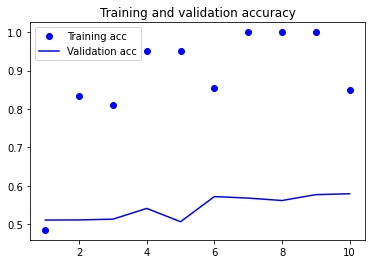

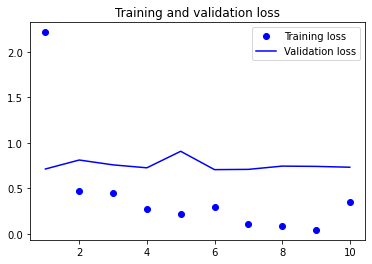

In [22]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


이 모델은 검증 정확도가 50% 후반이며 과대적합이 빠르게 시작됩니다. 훈련 샘플 수가 작기 때문입니다.

[과제] 사전 훈련된 임베딩을 사용하지 않고 상기 작업(샘플 200개)을 수행하여 비교해 보세요.

[과제] 훈련 샘플 수를 2000개로 늘려서 모델링 및 시각화 수행하여 상기 경우와 비교해 보세요.

단어 임베딩 : Word2Vec

https://doc.mindscale.kr/km/unstructured/11.html


[과제] 'https://www.gutenberg.org/files/2591/2591-0.txt' The Project Gutenberg 사이트 텍스트를 전처리 후 다음을 수행하세요.
- 사전 훈련된 Word2Vec을 gensim을 이용하여 임포트 후 cbow, skip-gram 방식으로 모델링하여 유사도 측정
  - wv.similarity('king','prince')
  - wv.most_similar('king')
  - most_similar(positive=['man','princess'], negative=['woman'])
- 옵션 사항
  - size(워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원) : 100
  - window(컨텍스트 윈도우 크기) : 3
  - min_count(단어 최소 빈도 수 제한-빈도가 적은 단어들은 학습하지 않는다.) : 3
  - workers(학습을 위한 프로세스 수) : 4
  - sg = 0은 CBOW, 1은 Skip-gram.


In [23]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove = ('headers','footers', 'quotes'))
documents = dataset.data 
print(len(documents))
documents[3]

11314


'Notwithstanding all the legitimate fuss about this proposal, how much\nof a change is it?  ATT\'s last product in this area (a) was priced over\n$1000, as I suspect \'clipper\' phones will be; (b) came to the customer \nwith the key automatically preregistered with government authorities. Thus,\naside from attempting to further legitimize and solidify the fed\'s posture,\nClipper seems to be "more of the same", rather than a new direction.\n   Yes, technology will eventually drive the cost down and thereby promote\nmore widespread use- but at present, the man on the street is not going\nto purchase a $1000 crypto telephone, especially when the guy on the other\nend probably doesn\'t have one anyway.  Am I missing something?\n   The real question is what the gov will do in a year or two when air-\ntight voice privacy on a phone line is as close as your nearest pc.  That\nhas got to a problematic scenario for them, even if the extent of usage\nnever surpasses the \'underground\' stature

In [43]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def clean_text(d):
  pattern = r'[^a-zA-Z\s]'
  d = re.sub(pattern, '', d)
  return d

def clean_stopwords(d):
  stop_words = stopwords.words('english')
  return ' '.join([w.lower() for w in d.split() if w not in stop_words and len(w) > 2])

def tokenize(d):
  return word_tokenize(d)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [45]:
import pandas as pd
news_df = pd.DataFrame({'article':documents})
len(news_df)

11314

In [46]:
news_df.replace("", float('Nan'), inplace=True)
news_df.dropna(inplace=True)
len(news_df)

11096

In [47]:
news_df['article'] = news_df['article'].apply(clean_text)
news_df['article']

0        Well im not sure about the story nad it did se...
1        \n\n\n\n\n\n\nYeah do you expect people to rea...
2        Although I realize that principle is not one o...
3        Notwithstanding all the legitimate fuss about ...
4        Well I will have to change the scoring on my p...
                               ...                        
11309    Danny Rubenstein an Israeli journalist will be...
11310                                                   \n
11311    \nI agree  Home runs off Clemens are always me...
11312    I used HP DeskJet with Orange Micros Grappler ...
11313                                          \nNo arg...
Name: article, Length: 11096, dtype: object

In [48]:
news_df['article'] = news_df['article'].apply(clean_stopwords)
news_df['article']

0        well sure story nad seem biased what disagree ...
1        yeah expect people read faq etc actually accep...
2        although realize principle one strongest point...
3        notwithstanding legitimate fuss proposal much ...
4        well change scoring playoff pool unfortunately...
                               ...                        
11309    danny rubenstein israeli journalist speaking t...
11310                                                     
11311    agree home runs clemens always memorable kinda...
11312    used deskjet orange micros grappler system but...
11313    argument murphy scared hell came last year han...
Name: article, Length: 11096, dtype: object

In [49]:
tokenized_news = news_df['article'].apply(tokenize)
tokenized_news = tokenized_news.to_list()
tokenized_news[168]

['animal', 'rights', 'people', 'know', 'bike', 'riding', 'dogscats', 'racoons']

In [50]:
len(tokenized_news)

11096

In [51]:
import numpy as np
drop_news = [index for index, sentence in enumerate(tokenized_news) if len(sentence) <= 1]
news_texts = np.delete(tokenized_news, drop_news, axis=0)
print(len(news_texts))

10964


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [52]:
# CBOW

from gensim.models import Word2Vec
model = Word2Vec(sentences = news_texts,
                 window = 4,
                 size = 100,
                 min_count=5,
                 workers=4,
                 sg=0)

In [55]:
model.wv.similarity('man','woman')

0.94553006

In [54]:
model.most_similar(positive=['soldiers'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('genocide', 0.9767663478851318),
 ('azerbaijani', 0.9764659404754639),
 ('armenia', 0.973975658416748),
 ('armenians', 0.9694497585296631),
 ('killed', 0.9691849946975708),
 ('murdered', 0.9688085913658142),
 ('turkey', 0.9664527773857117),
 ('turks', 0.9652689099311829),
 ('began', 0.9646092057228088),
 ('lived', 0.9596164226531982)]

In [53]:
model.wv.most_similar(positive=['man','soldiers'], negative=['woman'])

[('son', 0.9864121675491333),
 ('jewish', 0.9604703187942505),
 ('born', 0.9586650133132935),
 ('arab', 0.9528806209564209),
 ('jews', 0.9494990110397339),
 ('holy', 0.94776451587677),
 ('men', 0.9469165802001953),
 ('genocide', 0.9424422979354858),
 ('freewill', 0.936965823173523),
 ('henrik', 0.9367684721946716)]

[과제] skipgram으로 상기 과제를 수행하세요